**Hyperparameter Tuning for Optimized Pipeline Performance**

The task focused on optimizing a previously built **Pipeline** by tuning its **hyperparameters**. Using **GridSearch** and **validation subsets**, the goal was to find the **best combination of hyperparameters** to enhance the model’s performance. This approach ensured the **Pipeline** was not only automated for data preparation and modeling but also **fine-tuned** for optimal **F1_score** and **AUC**.

**🔍 More details and comments are available at the end of the file.**

**#0 Imports**

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data splitting into training/validation/test sets
from sklearn.model_selection import train_test_split, GridSearchCV

# Pipeline construction
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

# Dimensionality reduction
from sklearn.decomposition import PCA

# Model
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

**#1 Loading the dataset and preparing the data**

In [2]:
diabetes = pd.read_csv('diabetes.csv')
diabetes

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [4]:
X = diabetes.drop(['PatientID', 'Diabetic'], axis=1).copy()
y = diabetes['Diabetic'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

**#2 Function to calculate metrics**

In [5]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## Metrics for the checked model ################

    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # Plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    new_row = pd.DataFrame({'Model': [name], 'F1_score': [f1_metric], 'AUC': [auc_metric]})
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
    
    return metrics_dataframe

**#3 Preparation of numerical and categorical values**

In [6]:
# Numerical features
num_features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 
                'TricepsThickness', 'SerumInsulin', 'BMI', 
                'DiabetesPedigree', 'Age']

# Categorical features (none in this case)
cat_features = []

# Preparation of numerical values
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

# Preparation of categorical values (skipped, as there are no categorical features)
cat_preparation = None

# transformer = numerical and categorical values
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

**#4 Pipeline (without GridSearch)**

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2500
           1       0.74      0.57      0.64      1250

    accuracy                           0.79      3750
   macro avg       0.77      0.73      0.75      3750
weighted avg       0.78      0.79      0.78      3750



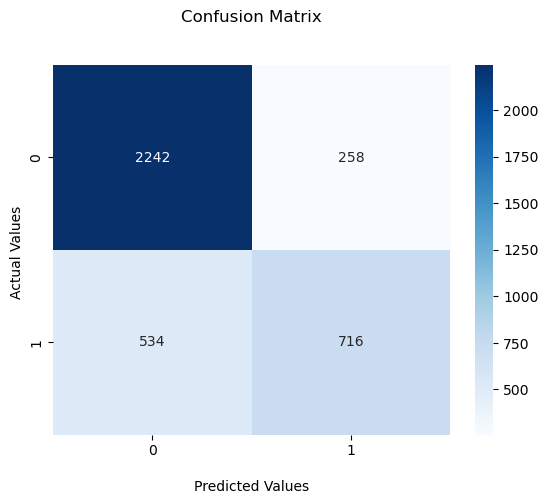

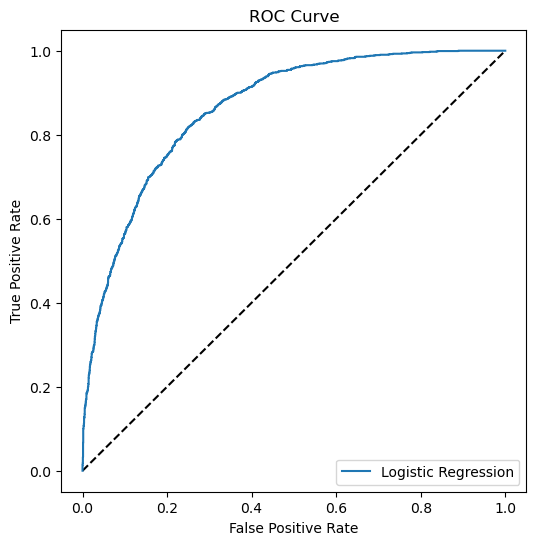

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_6988\2120828954.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)


,Model,F1_score,AUC
0,Logistic Regression,0.643885,0.864158


In [7]:
model_pipeline = Pipeline(steps=[('preprocessor', data_preparation),
                                  ('model', LogisticRegression(max_iter=10000))])

# Training and evaluation
model_pipeline.fit(X_train, y_train)
calculate_metrics(model_pipeline, 'Logistic Regression', X_test, y_test)

**#5 Creating a Pipeline with GridSearch**

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Best hyperparameters:
{'model__C': 0.2682695795279725, 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.99999, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 4}
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2500
           1       0.85      0.84      0.84      1250

    accuracy                           0.90      3750
   macro avg       0.88      0.88      0.88      3750
weighted avg       0.90      0.90      0.90      3750



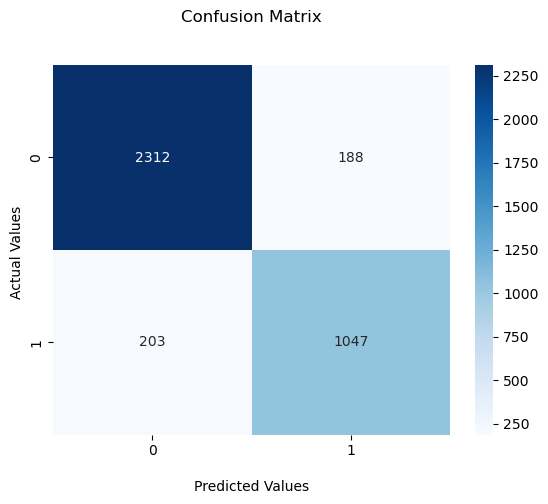

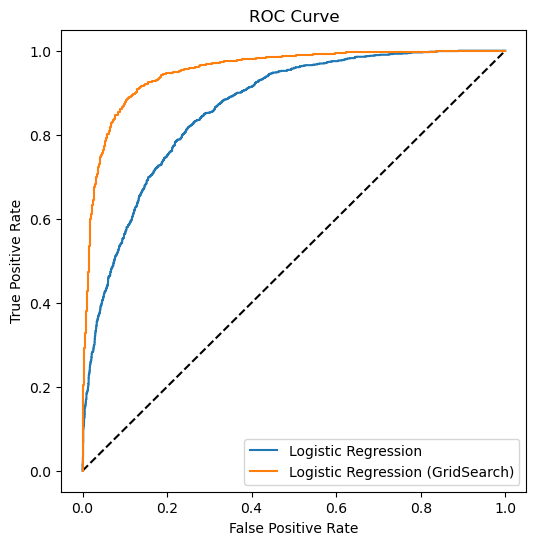

,Model,F1_score,AUC
0,Logistic Regression,0.643885,0.864158
1,Logistic Regression (GridSearch),0.842656,0.951845


In [8]:
model_pipeline_grid = Pipeline(steps=[('preprocessor', data_preparation),
                                      ('model', LogisticRegression(max_iter=10000))])

# Hyperparameter grid
params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

# GridSearchCV
grid_search = GridSearchCV(
    model_pipeline_grid,
    params,
    cv=10,
    n_jobs=-1,
    verbose=10,
    scoring='f1_macro'
)

# Perform GridSearch
grid_search.fit(X_train, y_train)

# GridSearch results
print("Best hyperparameters:")
print(grid_search.best_params_)

# Evaluate the model with the best parameters
best_model = grid_search.best_estimator_
calculate_metrics(best_model, 'Logistic Regression (GridSearch)', X_test, y_test)

**#6 Summary**

The **pipeline with GridSearch** clearly **improved** the model's performance compared to the version **without this optimization**. 
The F1_score increased from **0.643885 to 0.842656**, representing an improvement of about **30.9%**. 
The AUC parameter also increased from **0.864158 to 0.951845**, indicating a rise of about **10.1%**. 
These results clearly demonstrate that hyperparameter selection using **GridSearch** significantly **enhances the model's quality**.